# ___Corona Fake News Classification___

## ___Dataload___

In [1]:
# Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re

# NLTK
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

import string
from string import punctuation

import collections
from collections import Counter

# Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Reading the Data
df = pd.read_csv('/content/corona_fake.csv')
df.head()

,title,text,source,label
0,Due to the recent outbreak for the Coronavirus...,"You just need to add water, and the drugs and ...",coronavirusmedicalkit.com,Fake
1,NaN,Hydroxychloroquine has been shown to have a 10...,RudyGiuliani,Fake
2,NaN,Fact: Hydroxychloroquine has been shown to hav...,CharlieKirk,Fake
3,NaN,The Corona virus is a man made virus created i...,JoanneWrightForCongress,Fake
4,NaN,Doesn’t @BillGates finance research at the Wuh...,JoanneWrightForCongress,Fake


## ___Data Cleaning___

In [3]:
df.label.value_counts()

TRUE    584
Fake    345
fake    230
Name: label, dtype: int64

In [4]:
df['label'].replace('fake', 'FAKE', inplace = True)
df.label.value_counts()

TRUE    584
Fake    345
FAKE    230
Name: label, dtype: int64

In [5]:
df.isnull().sum()

title     82
text      10
source    20
label      5
dtype: int64

In [6]:
df[df['label'].isnull()]

,title,text,source,label
5,CORONA UNMASKED: Chinese Intelligence Officer ...,NaN,NaN,NaN
15,You can recover from the coronavirus disease (...,Most of the people who catch COVID-19 can reco...,https://www.who.int/emergencies/diseases/novel...,NaN
43,Pandemic Bio-Weapon – 9. Supervirus Created by...,NaN,NaN,NaN
131,Why the Coronavirus Seems to Hit Men Harder Th...,The coronavirus that originated in China has s...,NaN,NaN
242,The Coronavirus 5G Connection and Coverup,THE STORY:The China Coronavirus COVID-19 rose ...,https://www.wakingtimes.com/,NaN


In [7]:
df.loc[5]['label'] = 'FAKE'
df.loc[15]['label'] = 'TRUE'
df.loc[43]['label'] = 'FAKE'
df.loc[131]['label'] = 'TRUE'
df.loc[242]['label'] = 'FAKE'

df.title.fillna('missing', inplace=True)
df.source.fillna('missing', inplace=True)

In [8]:
df['title_text'] = df['title'] + ' ' + df['text']

In [9]:
df.label.value_counts()

TRUE    586
Fake    345
FAKE    233
Name: label, dtype: int64

In [10]:
df.head()

,title,text,source,label,title_text
0,Due to the recent outbreak for the Coronavirus...,"You just need to add water, and the drugs and ...",coronavirusmedicalkit.com,Fake,Due to the recent outbreak for the Coronavirus...
1,missing,Hydroxychloroquine has been shown to have a 10...,RudyGiuliani,Fake,missing Hydroxychloroquine has been shown to h...
2,missing,Fact: Hydroxychloroquine has been shown to hav...,CharlieKirk,Fake,missing Fact: Hydroxychloroquine has been show...
3,missing,The Corona virus is a man made virus created i...,JoanneWrightForCongress,Fake,missing The Corona virus is a man made virus c...
4,missing,Doesn’t @BillGates finance research at the Wuh...,JoanneWrightForCongress,Fake,missing Doesn’t @BillGates finance research at...


In [11]:
df.title_text = df.title_text.astype(str)

## ___Text-Preprocessing___

In [12]:
def text_cleaner(text):
  '''
    Make text lowercase, remove text in square brackets,remove links,remove special characters
    and remove words containing numbers.
    '''
  text = text.lower()
  text = re.sub('\[.*?\]', '', text)
  text = re.sub("\\W"," ",text) # remove special chars
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('\w*\d\w*', '', text)
  
  return text

df['title_text'] = df['title_text'].apply(text_cleaner)

In [13]:
df.head()

,title,text,source,label,title_text
0,Due to the recent outbreak for the Coronavirus...,"You just need to add water, and the drugs and ...",coronavirusmedicalkit.com,Fake,due to the recent outbreak for the coronavirus...
1,missing,Hydroxychloroquine has been shown to have a 10...,RudyGiuliani,Fake,missing hydroxychloroquine has been shown to h...
2,missing,Fact: Hydroxychloroquine has been shown to hav...,CharlieKirk,Fake,missing fact hydroxychloroquine has been show...
3,missing,The Corona virus is a man made virus created i...,JoanneWrightForCongress,Fake,missing the corona virus is a man made virus c...
4,missing,Doesn’t @BillGates finance research at the Wuh...,JoanneWrightForCongress,Fake,missing doesn t billgates finance research at...


In [14]:
def stemmer(text):
  ps = PorterStemmer()
  text = [ps.stem(word) for word in word_tokenize(text) if word not in set(stopwords.words('english'))]
  return text

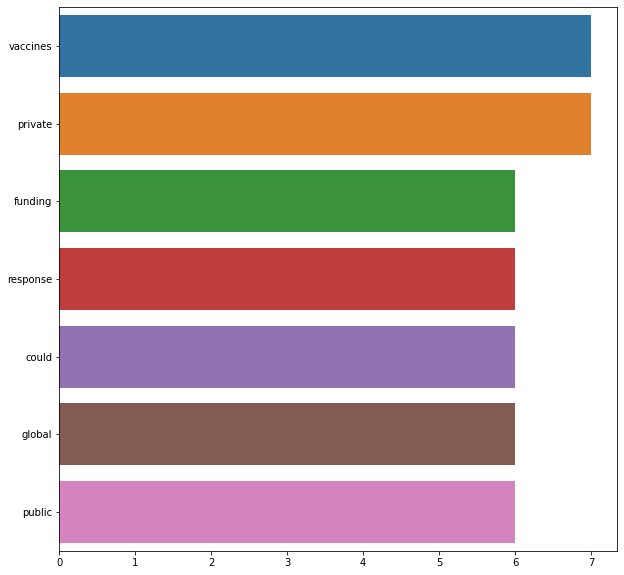

In [15]:
for i in df.title_text:
    global text
    text = i.split()
    
counter=Counter(text)
most=counter.most_common()

x, y= [], []
for word,count in most[:20]:
  if(word not in set(stopwords.words('english'))):
        x.append(word)
        y.append(count)
plt.figure(figsize = (10,10))     
sns.barplot(x=y,y=x)

## ___Vectorization___

In [16]:
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None,
                        tokenizer=stemmer,
                        use_idf=True,
                        norm='l2',
                        smooth_idf=True)

X = tfidf.fit_transform(df['title_text']).toarray()
y = df.label.values

## ___Modelling___

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3, shuffle=False)

In [18]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(814, 13450)
(814,)
(350, 13450)
(350,)


In [20]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

# fit
nb.fit(X_train, y_train)
#predict
nb_predict = nb.predict(X_test)

print("---Test Set Results---")
print("Accuracy: {}".format(accuracy_score(y_test, nb_predict)))
print(classification_report(y_test, nb_predict))

---Test Set Results---
Accuracy: 0.6657142857142857
              precision    recall  f1-score   support

        FAKE       0.11      0.53      0.18        15
        Fake       0.60      0.39      0.47       117
        TRUE       0.89      0.82      0.85       218

    accuracy                           0.67       350
   macro avg       0.53      0.58      0.50       350
weighted avg       0.76      0.67      0.70       350



In [21]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)

#fit
rf.fit(X_train, y_train)
#predict
rf_predict = rf.predict(X_test)

print("---Test Set Results---")
print("Accuracy: {}".format(accuracy_score(y_test, rf_predict)))
print(classification_report(y_test, rf_predict))

---Test Set Results---
Accuracy: 0.64
              precision    recall  f1-score   support

        FAKE       0.33      0.07      0.11        15
        Fake       1.00      0.04      0.08       117
        TRUE       0.64      1.00      0.78       218

    accuracy                           0.64       350
   macro avg       0.66      0.37      0.32       350
weighted avg       0.75      0.64      0.52       350



In [22]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0)

#fit
lr.fit(X_train, y_train)
#predict
lr_predict = lr.predict(X_test)

print("---Test Set Results---")
print("Accuracy: {}".format(accuracy_score(y_test, lr_predict)))
print(classification_report(y_test, lr_predict))

---Test Set Results---
Accuracy: 0.7457142857142857
              precision    recall  f1-score   support

        FAKE       0.06      0.20      0.09        15
        Fake       0.90      0.38      0.54       117
        TRUE       0.85      0.98      0.91       218

    accuracy                           0.75       350
   macro avg       0.60      0.52      0.51       350
weighted avg       0.83      0.75      0.75       350



In [23]:
# Logistic Regression with Cross Validation 
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(cv=5, scoring='accuracy', random_state=0, n_jobs=-1, verbose=3, max_iter=300).fit(X_train, y_train)
lr_cv_pred = clf.predict(X_test)

print("---Test Set Results---")
print("Accuracy: {}".format(accuracy_score(y_test, lr_cv_pred)))
print(classification_report(y_test, lr_cv_pred))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min finished


---Test Set Results---
Accuracy: 0.7571428571428571
              precision    recall  f1-score   support

        FAKE       0.07      0.27      0.11        15
        Fake       0.91      0.42      0.57       117
        TRUE       0.88      0.97      0.92       218

    accuracy                           0.76       350
   macro avg       0.62      0.55      0.54       350
weighted avg       0.85      0.76      0.77       350

